**Reading X-Ray Dicom Files**

Este notebook mostrará como abrir um arquivo dicom de um exame de Raio-X. Exploraremos algumas das diferenças práticas entre o manuseio de um arquivo dicom de um exame de TC (como mostramos nos cadernos até agora) e um Raio-X. Para este notebook, usaremos três arquivos dicom extraídos do conjunto de dados **[SIIM ACR Pneumothorax Segmentation Data](https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data)**.

Mais uma vez, vamos começar carregando o módulo util. Como não fizemos alterações neste módulo na parte anterior, carregaremos o módulo utils_pt2.py.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()
!conda install -c conda-forge gdcm
!pip install pydicom==2.0.0

from google.colab import drive
drive.mount('/content/drive')

✨🍰✨ Everything looks OK!
Solving environment: / - \ | / - \ | / - done

# All requested packages already installed.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!find "drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/modules/" -name "*.py" -exec cp {} ./ \;

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import utils_pt2 as utils

Agora, vamos usar a função get_valid_files_in_folder para construir um dataframe com algumas tags dicom. Observe que algumas das tags dicom usadas anteriormente estão faltando, pois para este teste, não precisaremos de todas essas tags.

In [4]:
XRAY_FOLDER = "drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/x-ray_example/"

dicom_fields = {   'SOPInstanceUID':{'mandatory':True},
                  'SeriesInstanceUID':{'mandatory':True},
                  'SeriesDescription':{'mandatory':False},
                  'StudyInstanceUID':{'mandatory':True},
                  'AcessionNumber':{'mandatory':False}, 
                  'PatientID':{'mandatory':False},
               }

df = utils.get_valid_files_in_folder(XRAY_FOLDER, dicom_fields)
df

,SOPInstanceUID,SeriesInstanceUID,SeriesDescription,StudyInstanceUID,AcessionNumber,PatientID,path
0,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,1.2.276.0.7230010.3.1.3.8323329.10002.15178752...,view: AP,1.2.276.0.7230010.3.1.2.8323329.10002.15178752...,Null,d19d956f-4ddd-4688-81ff-909c85e0e2d9,drive/MyDrive/Curso IA para Medicina - Cientis...
1,1.2.276.0.7230010.3.1.4.8323329.10007.15178752...,1.2.276.0.7230010.3.1.3.8323329.10007.15178752...,view: PA,1.2.276.0.7230010.3.1.2.8323329.10007.15178752...,Null,22e25a79-59b2-4e0c-88f3-6baba20c016e,drive/MyDrive/Curso IA para Medicina - Cientis...
2,1.2.276.0.7230010.3.1.4.8323329.10010.15178752...,1.2.276.0.7230010.3.1.3.8323329.10010.15178752...,view: AP,1.2.276.0.7230010.3.1.2.8323329.10010.15178752...,Null,112b4cd5-cbc1-44d3-b652-a009cf0c215e,drive/MyDrive/Curso IA para Medicina - Cientis...


Como podemos ver, extraímos apenas três arquivos dicom. Também podemos ver aqui uma diferença importante em relação aos raios X: diferentemente dos exames de TC, cada série de um raio X é composta por uma única imagem dicom. Ou seja, cada SeriesInstanceUID está associado a um único SOPInstanceUID. Aqui, temos 3 séries diferentes.

**Exploring an X-Ray Dicom File**

Agora vamos abrir o primeiro arquivo dicom no dataframe e imprimir seu conteúdo.

In [5]:
path = df['path'].to_list()[0]
dcm = utils.read_dicom(path)
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Observe que algumas tags dicom importantes estão faltando aqui. Por exemplo, não temos tags RescaleSlope ou RescaleIntercept. Também não temos informações de WindowCenter e WindowWidth. Vejamos então o que a matriz de pixels está armazenando:

In [6]:
img = dcm.pixel_array
print(f'min max img value = ({np.min(img)}, {np.max(img)})')

min max img value = (0, 255)


**Rewriting the get_dicom_img Function**

Como podemos ver, a matriz de pixels deste arquivo dicom em particular é uma imagem simples de 8 bits com cada pixel variando entre 0 e 255. Isso é relativamente comum quando se trata de arquivos de raios-x, pois as imagens de raios-x não têm um padrão concreto como tomografias (medidas em unidades de Hounsfield), embora os raios-x tenham uma interpretação física semelhante a uma tomografia computadorizada. Como um raio X mede a densidade do corpo humano ao longo de um feixe de raios X, ele não mede a densidade de cada voxel, mas sim a densidade ao longo de todo o feixe em um determinado eixo. Isso resulta em uma imagem sem medição fixa, e cada máquina de raio-x pode salvar a imagem usando diferentes intervalos. Neste caso, uma imagem de 8 bits. Algumas imagens de raios X usam as tags dicom RescaleSlope e RescaleIntercept, e outras não. Algumas imagens de raio-x usam as tags WindowCenter e WindowWidth, mas não todas. Portanto, os arquivos de raios-x não seguem um padrão estrito como as tomografias.

Em resumo, não podemos usar nossa função get_dicom_img desenvolvida na parte 2, pois esta função lê algumas dessas tags que podem estar faltando em um raio-x. Portanto, precisamos corrigir essa função para permitir algumas ou todas essas tags dicom:

In [11]:
def get_single_window_img(dicom_path, window_center=None, window_width=None):
	dicom = utils.read_dicom(dicom_path)
	img = dicom.pixel_array
	if 'MONOCHROME1' in dicom.PhotometricInterpretation:
		img = 2**dicom.BitsStored-img

	try:
		slope = utils.get_first_of_dicom_field_as_int(dicom.RescaleSlope)
		intercept = utils.get_first_of_dicom_field_as_int(dicom.RescaleIntercept)
	except:
		slope = 1
		intercept = 0

	if window_center is None:
		try:
			window_center = utils.get_first_of_dicom_field_as_int(dicom.WindowCenter) 
			window_width = utils.get_first_of_dicom_field_as_int(dicom.WindowWidth)
		except:
			window_center = None
			window_width = None

	img = (img*slope +intercept)

	if window_width is None:
		img_min = np.min(img)
		img_max = np.max(img)
		img = (img - img_min) / (img_max - img_min)		
	else:
		img_min = window_center - window_width//2
		img_max = window_center + window_width//2
		img[img<img_min] = img_min
		img[img>img_max] = img_max
		img = (img - img_min) / window_width

	return img


def get_dicom_img(path, window_center=None, window_width=None):
    img = None
    if window_center is None or window_width is None:
        img = get_single_window_img(path)
    elif type(window_center) == list:
        img = []
        for i in range(len(window_center)):
            img_ch = get_single_window_img(path, window_center[i], window_width[i])
            img.append(img_ch)
        img = np.array(img)
        img = np.moveaxis(img, 0, 2)
    else:
        img = get_single_window_img(path, window_center, window_width)
    
    return img

Com essas funções corrigidas, vamos testá-las nos arquivos dicom extraídos do dataset:

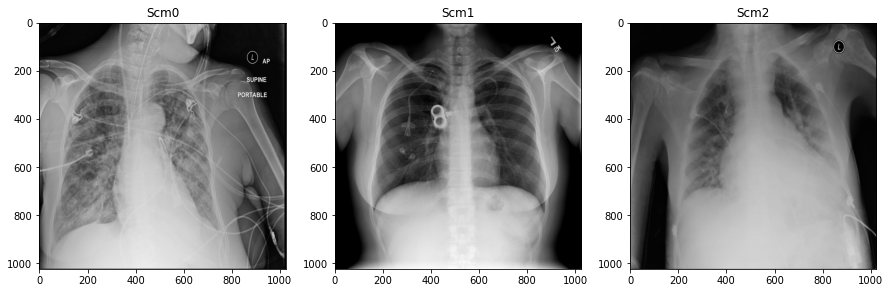

In [12]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
for i, path in enumerate(df['path']. to_list()):
  img = get_dicom_img(path)
  axarr[i].imshow(img, cmap='gray')
  axarr[i].title.set_text(f'Scm{i}')

**Using Custom Window Parameters for X-Rays**

Observe que nossa função ainda permite parâmetros de janela personalizados mesmo quando nenhuma tag de janela está presente. Vamos testar esse recurso carregando os mesmos três raios X com diferentes parâmetros de janela:

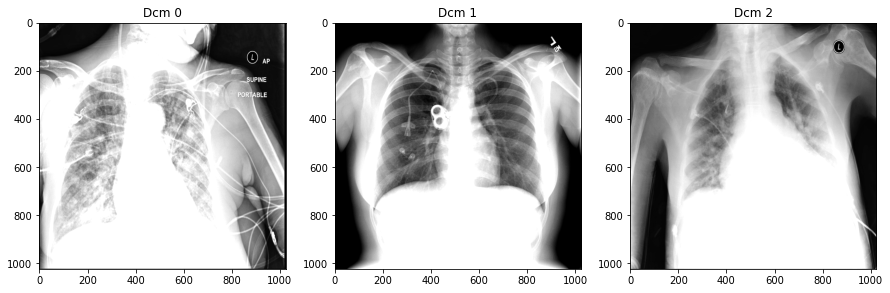

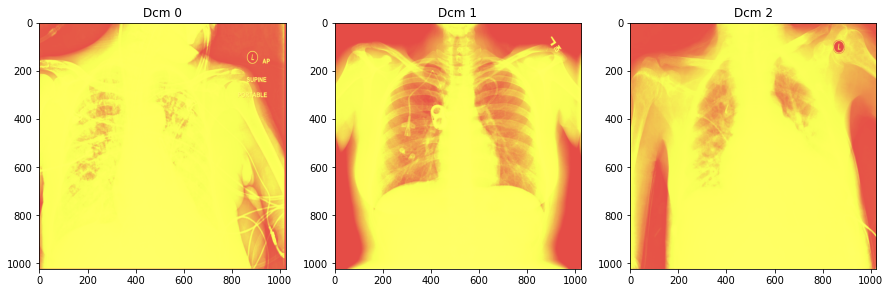

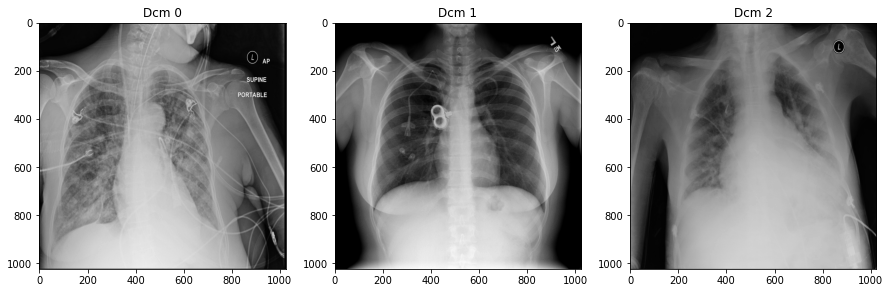

In [13]:
window_center_list = [-600, 30, 400]
window_width_list = [1500, 150, 1800]

wc = [-600, window_center_list, 400]
ww = [1500, window_width_list, 1800]

for j in range(len(wc)):
	f, axarr = plt.subplots(1, 3, figsize=(15,15))
	for i, path in enumerate(df['path'].to_list()):
		img = get_dicom_img(path, window_center=wc[j], window_width=ww[j])
		axarr[i].imshow(img, cmap='gray')
		axarr[i].title.set_text(f'Dcm {i}')